In [404]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# 한글 폰트 설정
plt.rcParams.update({'font.family' : 'Malgun Gothic'}) # 맑은 고딕 설정
plt.rcParams.update({'axes.unicode_minus' : False}) # 음수 기호 깨짐 방지

In [405]:
# 데이터 불러오기
raw_building = pd.read_csv('../data/data_week2.csv', encoding='cp949')
train_chungju = pd.read_csv('../data/train_chungju_new.csv', encoding='utf-8')
test_chungju = pd.read_csv('../data/test_2020.csv', encoding='utf-8')

### 데이터 전처리, 파악

In [406]:
### 변수명 변경
building_df = raw_building.rename(columns={
    '전력사용량(kWh)': '전력사용량',
    '기온(°C)': '기온',
    '풍속(m/s)': '풍속',
    '습도(%)': '습도',
    '강수량(mm)': '강수량',
    '일조(hr)': '일조'
}, inplace=False)

train_SolarEnergy = train_chungju.rename(columns={
    '일시': 'date_time',
    '기온(°C)': '기온',
    '풍속(m/s)': '풍속',
    '습도(%)': '습도',
    '강수량(mm)': '강수량',
    '일조(hr)': '일조',
    '일사(MJ/m2)': '일사'
}, inplace=False)

test_SolarEnergy = test_chungju.rename(columns={
    '일시': 'date_time',
    '기온(°C)': '기온',
    '풍속(m/s)': '풍속',
    '습도(%)': '습도',
    '강수량(mm)': '강수량',
    '일조(hr)': '일조',
    '일사(MJ/m2)': '일사'
}, inplace=False)

print(building_df.columns) # 바뀐거 확인
print(train_SolarEnergy.columns)
print(test_SolarEnergy.columns)

Index(['num', 'date_time', '전력사용량', '기온', '풍속', '습도', '강수량', '일조', '비전기냉방설비운영',
       '태양광보유'],
      dtype='object')
Index(['date_time', '기온', '강수량', '풍속', '습도', '일조', '일사'], dtype='object')
Index(['date_time', '기온', '강수량', '풍속', '습도', '일조', '일사'], dtype='object')


In [407]:
building_df.head()

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [408]:
building_df.tail()

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0
122399,60,2020-08-24 23,3204.576,27.1,2.6,75.0,0.0,0.0,1.0,1.0


In [409]:
building_df.shape

(122400, 10)

In [410]:
train_SolarEnergy.head()

,date_time,기온,강수량,풍속,습도,일조,일사
0,2017-01-01 00:00,2.4,NaN,0.5,78,NaN,NaN
1,2017-01-01 01:00,2.2,NaN,0.2,78,NaN,NaN
2,2017-01-01 02:00,1.9,NaN,0.5,80,NaN,NaN
3,2017-01-01 03:00,1.1,NaN,0.5,83,NaN,NaN
4,2017-01-01 04:00,1.0,NaN,0.0,84,NaN,NaN


In [411]:
train_SolarEnergy.shape

(29927, 7)

In [412]:
test_SolarEnergy.head()

,date_time,기온,강수량,풍속,습도,일조,일사
0,2020-06-01 00:00,20.7,0.0,0.8,65.0,NaN,NaN
1,2020-06-01 01:00,18.1,0.0,1.1,87.0,NaN,NaN
2,2020-06-01 02:00,18.0,0.1,0.8,91.0,NaN,NaN
3,2020-06-01 03:00,18.0,0.5,1.1,92.0,NaN,NaN
4,2020-06-01 04:00,18.2,0.0,1.1,91.0,NaN,NaN


In [413]:
test_SolarEnergy.shape

(2040, 7)

In [414]:
### 데이터 타입 변경
# 빌딩 데이터
building_df.info()
building_df["num"] = building_df["num"].astype("object") # num -> object 형식으로 변환
building_df['date_time'] = pd.to_datetime(building_df['date_time']) # date_time -> datetime 형식으로 변환
building_df[["비전기냉방설비운영", "태양광보유"]] = building_df[["비전기냉방설비운영", "태양광보유"]].astype("bool") # 비전기냉방설비운영, 태양광보유 -> bool 값으로 변경
print(building_df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   num        122400 non-null  int64  
 1   date_time  122400 non-null  object 
 2   전력사용량      122400 non-null  float64
 3   기온         122400 non-null  float64
 4   풍속         122400 non-null  float64
 5   습도         122400 non-null  float64
 6   강수량        122400 non-null  float64
 7   일조         122400 non-null  float64
 8   비전기냉방설비운영  122400 non-null  float64
 9   태양광보유      122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB
num                  object
date_time    datetime64[ns]
전력사용량               float64
기온                  float64
풍속                  float64
습도                  float64
강수량                 float64
일조                  float64
비전기냉방설비운영              bool
태양광보유                  bool
dtype: object


In [415]:
# 청주 train 데이터
train_SolarEnergy.info()
train_SolarEnergy['date_time'] = pd.to_datetime(train_SolarEnergy['date_time']) # datetime 형식으로 변환
print(train_SolarEnergy.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29927 entries, 0 to 29926
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date_time  29927 non-null  object 
 1   기온         29927 non-null  float64
 2   강수량        2702 non-null   float64
 3   풍속         29926 non-null  float64
 4   습도         29927 non-null  int64  
 5   일조         16352 non-null  float64
 6   일사         16345 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.6+ MB
date_time    datetime64[ns]
기온                  float64
강수량                 float64
풍속                  float64
습도                    int64
일조                  float64
일사                  float64
dtype: object


In [416]:
# 청주 test 데이터
test_SolarEnergy.info()
test_SolarEnergy['date_time'] = pd.to_datetime(test_SolarEnergy['date_time']) # datetime 형식으로 변환
print(test_SolarEnergy.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date_time  2040 non-null   object 
 1   기온         2040 non-null   float64
 2   강수량        518 non-null    float64
 3   풍속         2040 non-null   float64
 4   습도         2038 non-null   float64
 5   일조         1275 non-null   float64
 6   일사         1275 non-null   float64
dtypes: float64(6), object(1)
memory usage: 111.7+ KB
date_time    datetime64[ns]
기온                  float64
강수량                 float64
풍속                  float64
습도                  float64
일조                  float64
일사                  float64
dtype: object


In [417]:
building_df.describe()

,date_time,전력사용량,기온,풍속,습도,강수량,일조
count,122400,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000
mean,2020-07-13 11:30:00.000000256,2324.830866,24.251713,2.151641,80.169848,0.514989,0.213533
min,2020-06-01 00:00:00,0.000000,11.100000,0.000000,19.000000,0.000000,0.000000
25%,2020-06-22 05:45:00,1055.268000,21.800000,1.100000,70.000000,0.000000,0.000000
50%,2020-07-13 11:30:00,1700.352000,24.200000,1.900000,84.000000,0.000000,0.000000
75%,2020-08-03 17:15:00,2780.487000,26.500000,2.900000,93.000000,0.000000,0.300000
max,2020-08-24 23:00:00,17739.225000,36.300000,20.100000,100.000000,81.500000,1.000000
std,NaN,2058.999326,3.407902,1.514475,15.525862,2.624505,0.370517


In [418]:
train_SolarEnergy.describe()

,date_time,기온,강수량,풍속,습도,일조,일사
count,29927,29927.000000,2702.000000,29926.000000,29927.000000,16352.000000,16345.000000
mean,2018-09-16 11:55:31.626958848,13.213246,1.394523,1.528106,59.238514,0.542191,1.122335
min,2017-01-01 00:00:00,-15.600000,0.000000,0.000000,10.000000,0.000000,0.000000
25%,2017-11-08 18:30:00,4.100000,0.000000,0.800000,44.000000,0.000000,0.240000
50%,2018-09-16 12:00:00,13.600000,0.100000,1.400000,60.000000,0.700000,0.910000
75%,2019-07-25 05:30:00,22.300000,1.200000,2.100000,75.000000,1.000000,1.830000
max,2020-05-31 23:00:00,38.100000,86.200000,7.700000,100.000000,1.000000,3.800000
std,NaN,10.784507,4.277216,0.972506,19.682066,0.447674,0.972006


In [419]:
test_SolarEnergy.describe()

,date_time,기온,강수량,풍속,습도,일조,일사
count,2040,2040.000000,518.000000,2040.000000,2038.000000,1275.000000,1275.000000
mean,2020-07-13 11:30:00,25.223775,1.590347,1.470245,73.354269,0.324941,1.128447
min,2020-06-01 00:00:00,15.900000,0.000000,0.000000,19.000000,0.000000,0.040000
25%,2020-06-22 05:45:00,22.700000,0.000000,0.900000,63.000000,0.000000,0.260000
50%,2020-07-13 11:30:00,25.100000,0.100000,1.400000,76.000000,0.000000,0.770000
75%,2020-08-03 17:15:00,27.500000,1.375000,1.900000,86.000000,0.800000,1.810000
max,2020-08-24 23:00:00,34.000000,34.200000,5.200000,96.000000,1.000000,3.860000
std,NaN,3.413885,3.495859,0.803219,14.982304,0.410045,1.025027


In [420]:
#### 결측치 처리
## 빌딩 데이터
building_df.isna().sum() # 결측치 없음

num          0
date_time    0
전력사용량        0
기온           0
풍속           0
습도           0
강수량          0
일조           0
비전기냉방설비운영    0
태양광보유        0
dtype: int64

In [421]:
## 태양에너지 트레인 데이터
train_SolarEnergy.isna().sum()
train_SolarEnergy[train_SolarEnergy['풍속'].isna()] # 20971 번째 행이 문제.

# 날씨는 이어진다. 그 사이 데이터를 보자.
train_SolarEnergy.iloc[20961: 20981, :] # 그 전 후 1시간동안 2.5였음.
# 똑같이 2.5(m/s)로 처리하자.
train_SolarEnergy.loc[20971, '풍속'] = 2.5

# 강수량, 일조, 일사는. 비가 안 왔을 때, 해가 뜨지 않았을 때 값이 없는 것으로 판단.
# 전부 0으로 처리
train_SolarEnergy = train_SolarEnergy.fillna(0)
train_SolarEnergy.isna().sum()

date_time    0
기온           0
강수량          0
풍속           0
습도           0
일조           0
일사           0
dtype: int64

In [422]:
## 태양에너지 테스트 데이터
test_SolarEnergy.isna().sum()
test_SolarEnergy[test_SolarEnergy['습도'].isna()] # 673, 674 번째 행이 문제.
# 2020-06-29 1시와 2시에 습도 데이터가 없는 거구나!

# 날씨는 이어진다. 그 사이 데이터를 보자.
test_SolarEnergy.iloc[663: 684, :] # 2시간 사이에 64.0 에서 82.0으로 바뀌었다!

# 한 시간에 6%씩 습도가 오른거로 치자.
test_SolarEnergy.loc[673, '습도'] = 70
test_SolarEnergy.loc[674, '습도'] = 76

# 강수량, 일조, 일사는. 비가 안 왔을 때, 해가 뜨지 않았을 때 값이 없는 것으로 판단.
# 전부 0으로 처리
test_SolarEnergy = test_SolarEnergy.fillna(0)
test_SolarEnergy.isna().sum()

date_time    0
기온           0
강수량          0
풍속           0
습도           0
일조           0
일사           0
dtype: int64

## EDA

In [423]:
# 월, 일, 시, 월+일 컬럼 추가
building_df['월'] = building_df['date_time'].dt.month
building_df['일'] = building_df['date_time'].dt.day
building_df['시'] = building_df['date_time'].dt.hour
building_df['월+일'] = building_df['date_time'].dt.strftime('%m/%d')

# 요일 컬럼 추가 (월요일, 화요일, ...)
building_df['요일'] = building_df['date_time'].dt.day_name()

# 주말, 평일(토, 일) 추가
building_df = building_df.assign(주말or평일 = np.where(building_df['요일'] == ('Saturday' or 'Sunday'), 'weekend', 'weekday'))

In [424]:
building_df.head()

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,월,일,시,월+일,요일,주말or평일
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,False,False,6,1,0,06/01,Monday,weekday
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,False,False,6,1,1,06/01,Monday,weekday
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,False,False,6,1,2,06/01,Monday,weekday
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,False,False,6,1,3,06/01,Monday,weekday
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,False,False,6,1,4,06/01,Monday,weekday


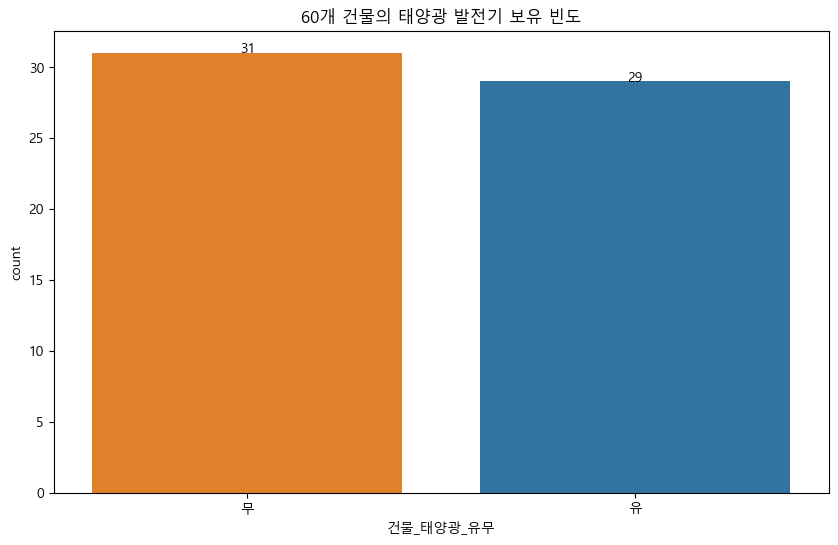

In [425]:
##### 태양광 변수에 대해서 조금 더 EDA
# 60개 건물의 태양광 발전기 보유 빈도 그래프
solar_generator_YorN = building_df.groupby('num', as_index=False)\
                                  .agg(건물_태양광_유무 = ('태양광보유', 'mean'))
solar_generator_YorN['건물_태양광_유무'] = solar_generator_YorN['건물_태양광_유무'].astype("object")
solar_generator_YorN.loc[solar_generator_YorN['건물_태양광_유무'] == 0, '건물_태양광_유무'] = '무'
solar_generator_YorN.loc[solar_generator_YorN['건물_태양광_유무'] == 1, '건물_태양광_유무'] = '유'

plt.figure(figsize=(10, 6))
ax = sns.countplot(data = solar_generator_YorN, x = '건물_태양광_유무', hue= '건물_태양광_유무', hue_order='유무')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, # x 좌표
            p.get_y() + p.get_height() , # y 좌표
            f"{p.get_height():.0f}", # 값
            ha='center') # 가운데 정렬
plt.title('60개 건물의 태양광 발전기 보유 빈도')
plt.show()

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 [Text(0, 0.0, '0'),
  Text(0, 2000.0, '2000'),
  Text(0, 4000.0, '4000'),
  Text(0, 6000.0, '6000'),
  Text(0, 8000.0, '8000'),
  Text(0, 10000.0, '10000')])

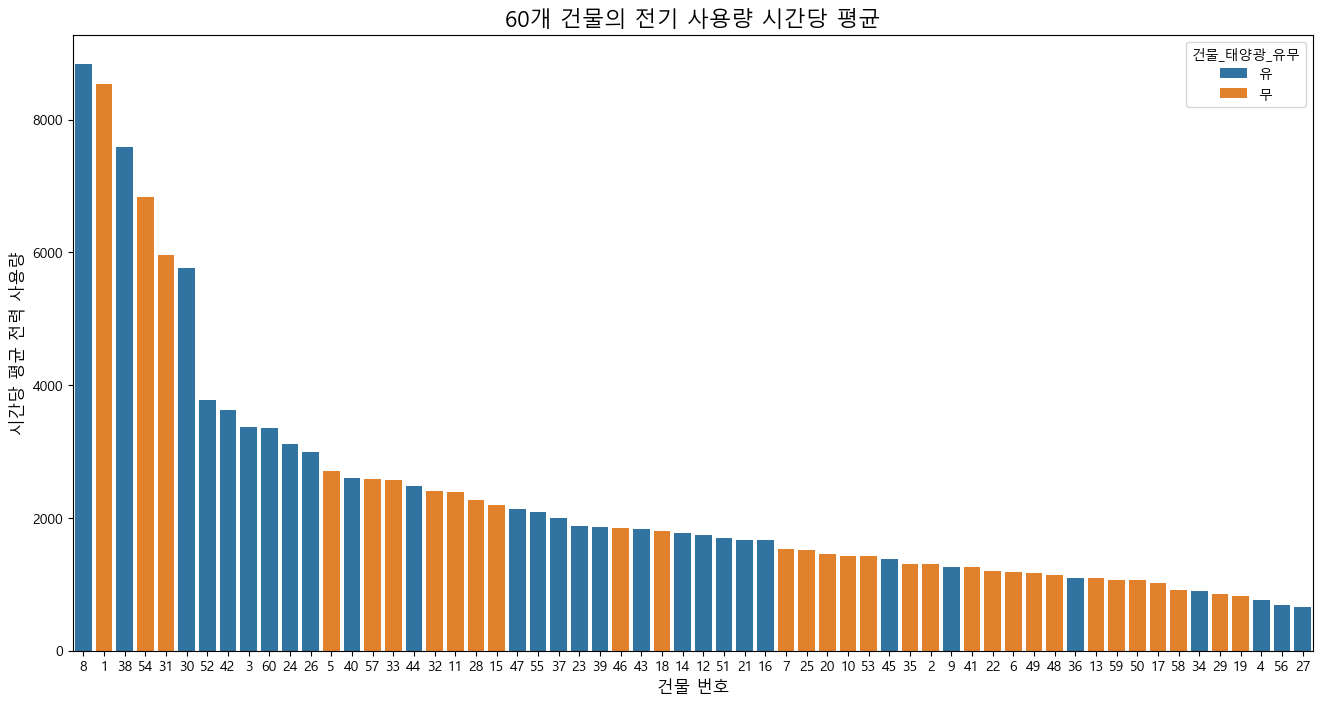

In [426]:
# 각 건물 별 전력 사용량 평균 그래프
elec_mean_df = building_df.groupby('num', as_index=False)\
                          .agg(mean_elec = ('전력사용량', 'mean'))\
                          .sort_values('mean_elec', ascending= False)
elec_mean_df = pd.merge(elec_mean_df, solar_generator_YorN, how = 'left', on = 'num')

plt.figure(figsize=(16, 8))
sns.barplot(data = elec_mean_df, x = 'num', y = 'mean_elec', order = elec_mean_df['num'], hue = '건물_태양광_유무', hue_order='유무')
plt.title('60개 건물의 전기 사용량 시간당 평균', fontsize=16) # 그래프 제목 추가 및 글자 크기 설정
plt.xlabel('건물 번호', fontsize=12)
plt.ylabel('시간당 평균 전력 사용량', fontsize=12)
plt.xticks(fontsize=10) # x축 레이블 글자 크기 설정
plt.yticks(fontsize=10) # y축 레이블 글자 크기 설정

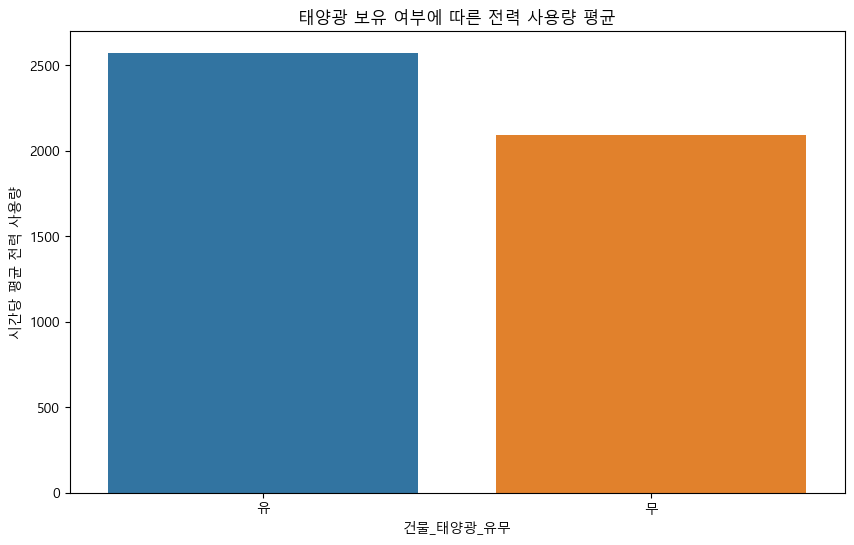

In [427]:
# 태양광 보유 유무에 따른 전력사용량
# Bar plot 시각화 (평균값)
my_df = elec_mean_df.groupby('건물_태양광_유무', as_index=False).agg(mean_elec = ('mean_elec', 'mean')).sort_values('mean_elec', ascending= False)

plt.figure(figsize=(10, 6))
sns.barplot(x='건물_태양광_유무', y='mean_elec', data=my_df, hue= '건물_태양광_유무', hue_order='유무')
plt.title('태양광 보유 여부에 따른 전력 사용량 평균')
plt.ylabel('시간당 평균 전력 사용량')
plt.show()

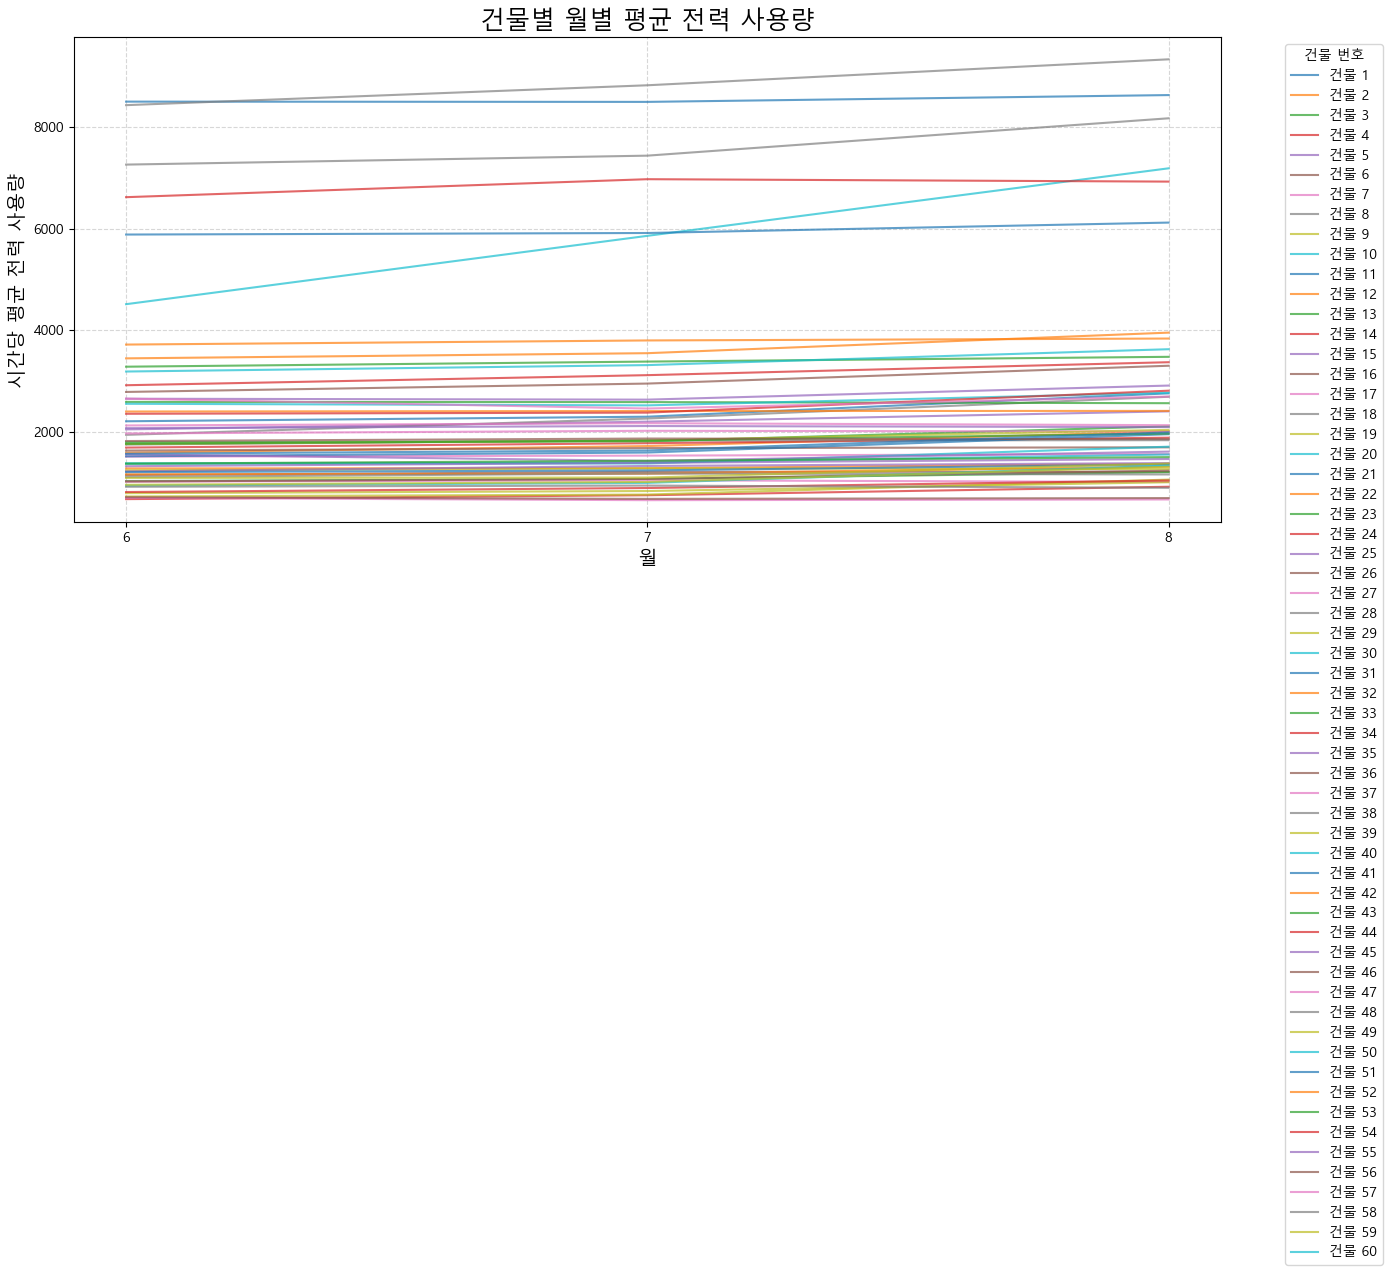

In [428]:
# 월별 전력사용량 건물별 평균 데이터 만들기
monthly_mean = building_df.groupby(['num', '월'])['전력사용량'].mean().reset_index()
monthly_mean

# 그래프 설정
plt.figure(figsize=(14, 10))

# 각 건물의 평균 전력 사용량 시각화
for i in monthly_mean['num'].unique():
    monthly_df = monthly_mean[monthly_mean['num'] == i]
    plt.plot(monthly_df['월'], monthly_df['전력사용량'], label=f'건물 {i}', alpha=0.7)

# 그래프 꾸미기
plt.title('건물별 월별 평균 전력 사용량', fontsize=18)
plt.xlabel('월', fontsize=14)
plt.ylabel('시간당 평균 전력 사용량', fontsize=14)
plt.xticks(range(6,9))  # 세 개의 달 x축 눈금
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='건물 번호', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

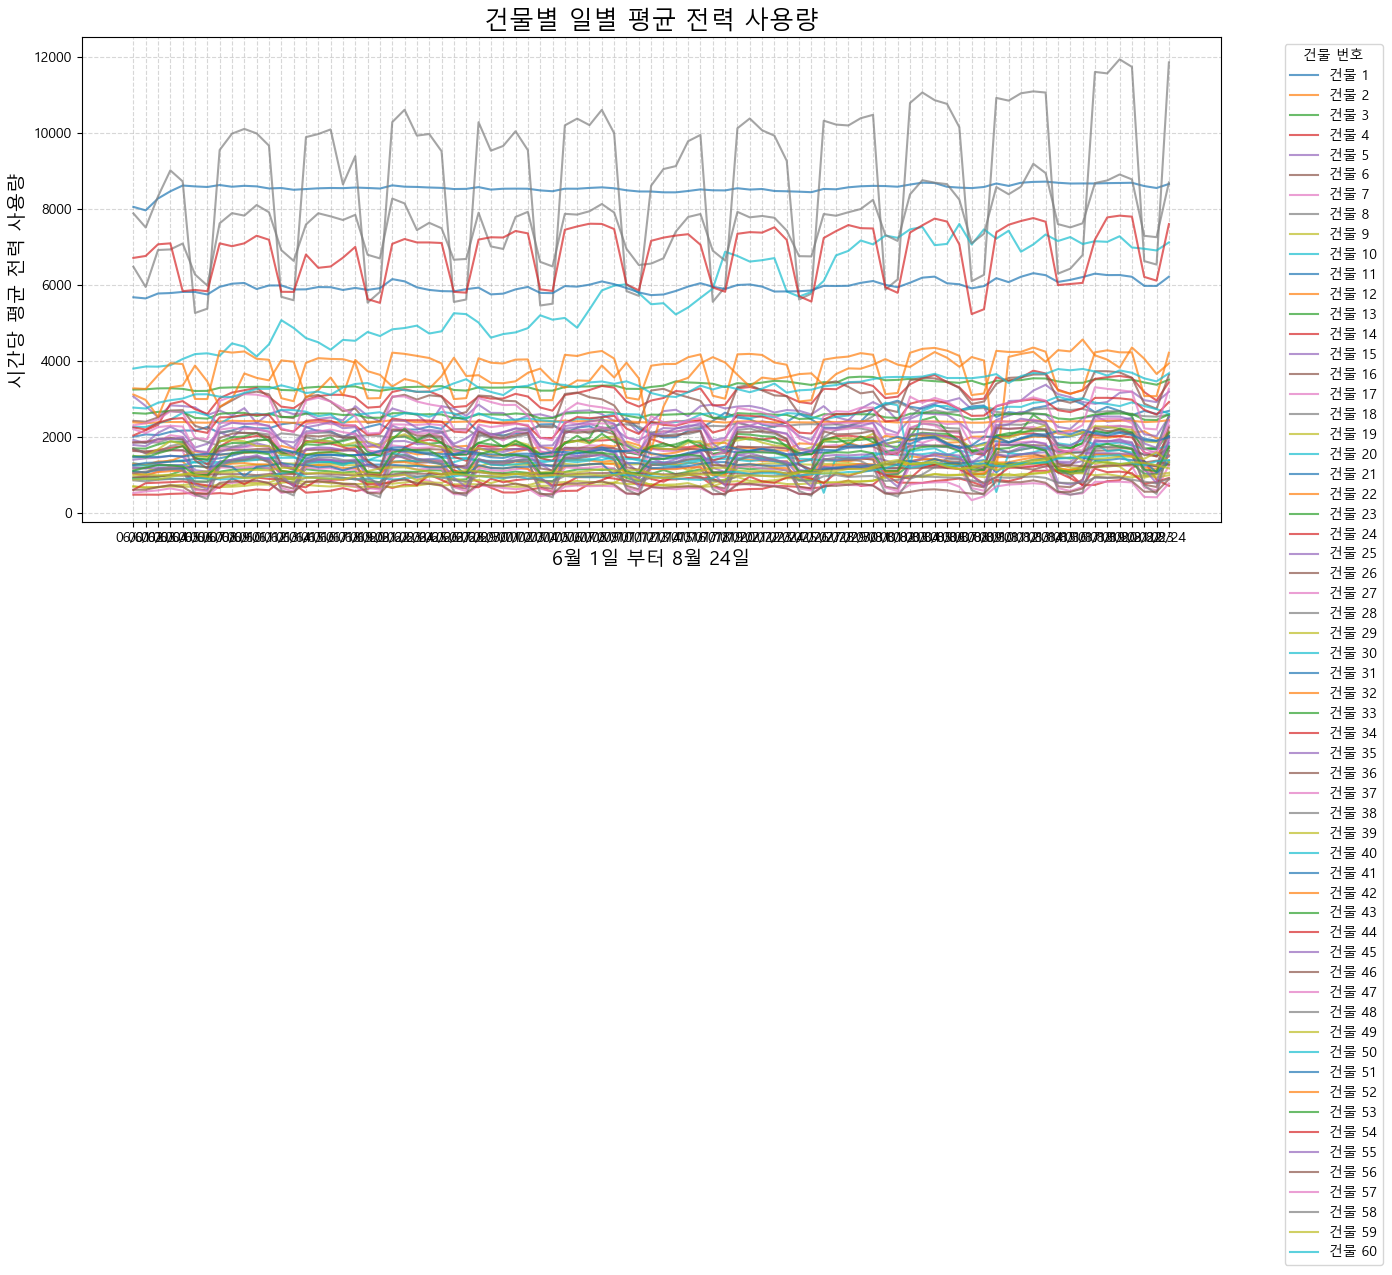

In [429]:
# 일별 전력사용량 건물별 평균 데이터 만들기
daily_mean = building_df.groupby(['num', '월+일'])['전력사용량'].mean().reset_index()
daily_mean

# 그래프 설정
plt.figure(figsize=(14, 10))

# 각 건물의 평균 전력 사용량 시각화
for i in daily_mean['num'].unique():
    daily_df = daily_mean[daily_mean['num'] == i]
    plt.plot(daily_df['월+일'], daily_df['전력사용량'], label=f'건물 {i}', alpha=0.7)

# 그래프 꾸미기
plt.title('건물별 일별 평균 전력 사용량', fontsize=18)
plt.xlabel('6월 1일 부터 8월 24일', fontsize=14)
plt.ylabel('시간당 평균 전력 사용량', fontsize=14)
plt.xticks(range(0, 85))  # 0시부터 23시까지 x축 눈금
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='건물 번호', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

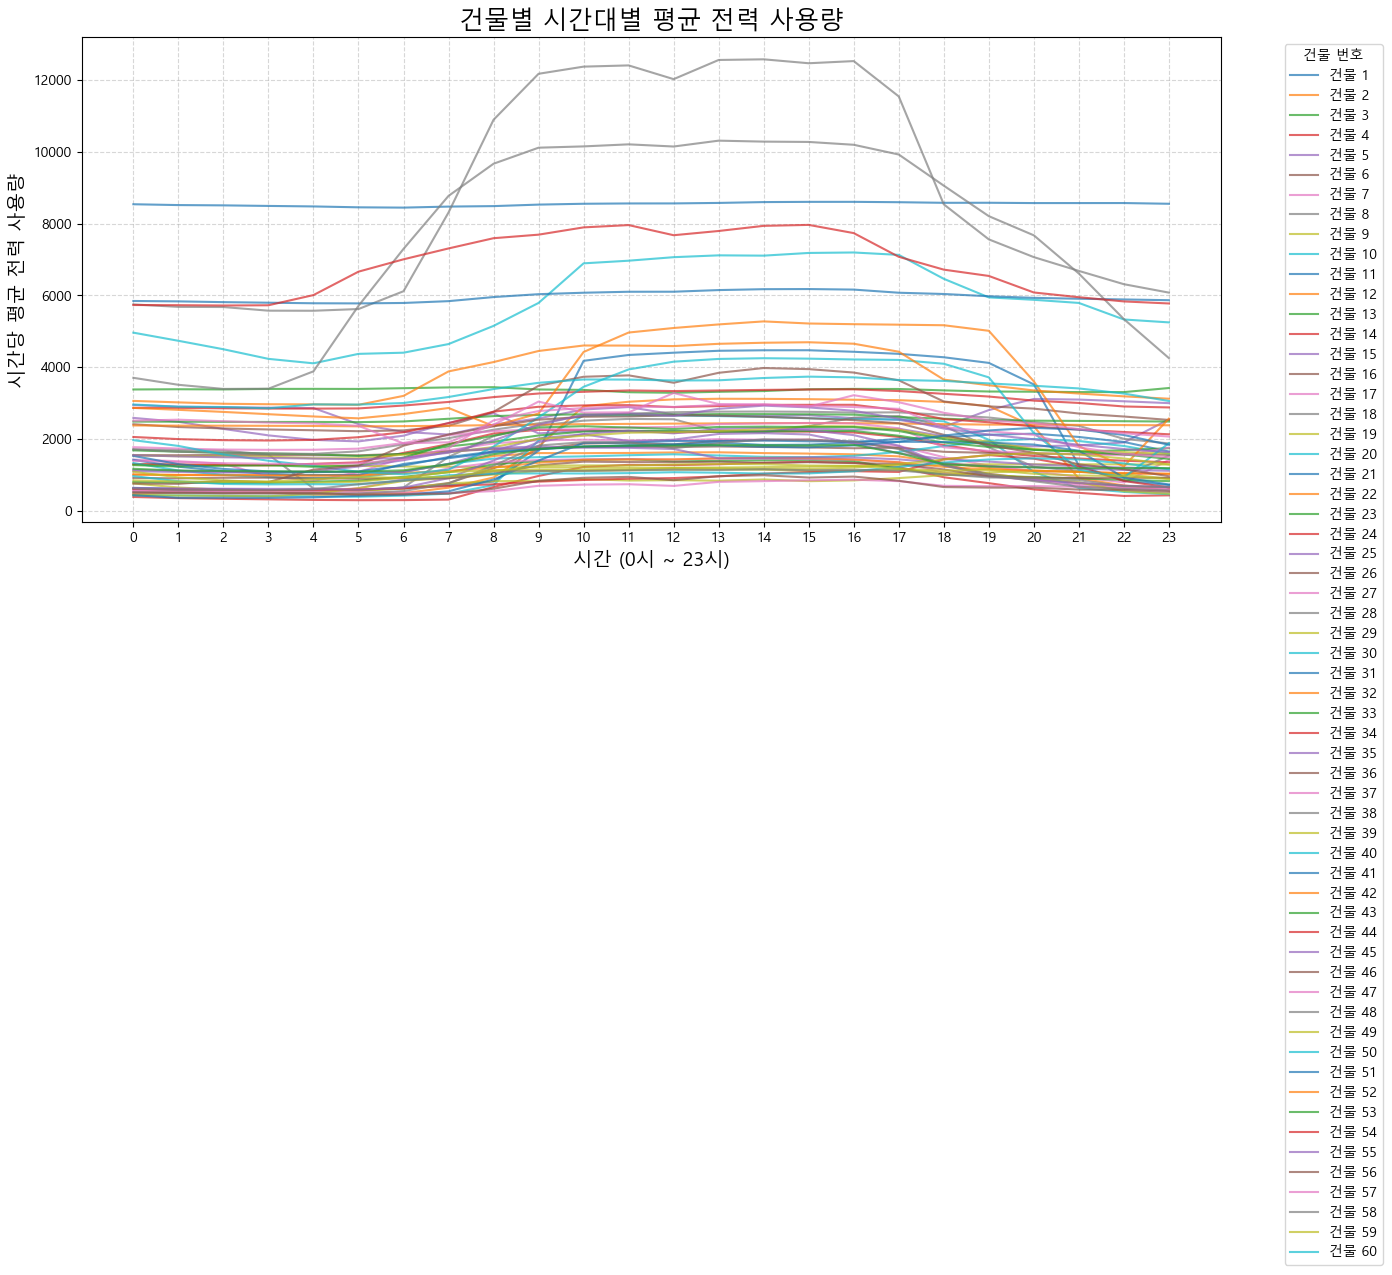

In [430]:
# 시간별 전력사용량 건물별 평균 데이터 만들기
hourly_mean = building_df.groupby(['num', '시'])['전력사용량'].mean().reset_index()
hourly_mean

# 그래프 설정
plt.figure(figsize=(14, 10))

# 각 건물의 평균 전력 사용량 시각화
for i in hourly_mean['num'].unique():
    hourly_df = hourly_mean[hourly_mean['num'] == i]
    plt.plot(hourly_df['시'], hourly_df['전력사용량'], label=f'건물 {i}', alpha=0.7)

# 그래프 꾸미기
plt.title('건물별 시간대별 평균 전력 사용량', fontsize=18)
plt.xlabel('시간 (0시 ~ 23시)', fontsize=14)
plt.ylabel('시간당 평균 전력 사용량', fontsize=14)
plt.xticks(range(0, 24))  # 0시부터 23시까지 x축 눈금
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='건물 번호', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

### 모델 만들기

In [431]:
# 모델 만들기 위해서 X, y 나누기. 트레인과 테스트는 이미 나눠져 있다.
X_train = train_SolarEnergy[['기온', '강수량', '풍속', '습도', '일조']]
y_train = train_SolarEnergy['일사']

X_test = test_SolarEnergy[['기온', '강수량', '풍속', '습도', '일조']]
y_test = test_SolarEnergy['일사']